# MNIST Handwritten Digit Problem #2
The objective of this notebook is to combine network design with optimization methods.  We will re-solve the MNIST digit problem with more advanced tools.  You should target an error rate of 2%.

In [30]:
require 'nn'
require 'paths'
require 'optim'
print('ready')

-- set the number of threads [set to number of cores]
torch.setnumthreads(16)

ready	


In [12]:
-- snippet shamelessly ripped from https://github.com/torch/tutorials/blob/master/A_datasets/mnist.lua 
-- load the training data (downloads when first used)
tar = 'http://torch7.s3-website-us-east-1.amazonaws.com/data/mnist.t7.tgz'

if not paths.dirp('mnist.t7') then
   print('==> downloading dataset')
   os.execute('wget ' .. tar)
   os.execute('tar xvf ' .. paths.basename(tar))
end

train_file = 'mnist.t7/train_32x32.t7'
test_file = 'mnist.t7/test_32x32.t7'

----------------------------------------------------------------------
print('==> loading dataset')

-- We load the dataset from disk (it's straightforward if we have it in the right format t7)
train_data = torch.load(train_file,'ascii')
test_data = torch.load(test_file,'ascii')

==> loading dataset	

In [13]:
-- print some training data
print(train_data)

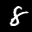

In [14]:
-- example image
itorch.image(train_data.data[{500,1}])

In [15]:
-- raw data
train_data.data[{500,1}]

In [16]:
-- let's preprocess the data a bit, so they are between 0 and 1
train_data.data = train_data.data:reshape(60000, 32*32):type('torch.DoubleTensor'):mul(1.0 / 256.0)
test_data.data = test_data.data:reshape(10000, 32*32):type('torch.DoubleTensor'):mul(1.0 / 256.0)

-- remove mean
--train_data.data = train_data.data - torch.repeatTensor(torch.mean(train_data.data,2),1,1024)
--test_data.data = test_data.data - torch.repeatTensor(torch.mean(test_data.data,2),1,1024)

 0    0    0    0
 221  252  117    0    0    0    0    0    0    0    0    0    0    0    0    0
 137  252  189    0    0    0    0    0    0    0    0    0    0    0    0    0
 123  253  253   11    0    0    0    0    0    0    0    0    0    0    0    0
 142  252  252   63    0    0    0    0    0    0    0    0    0    0    0    0
 234  252  168   32    0    0    0    0    0    0    0    0    0    0    0    0
 252  176   25    0    0    0    0    0    0    0    0    0    0    0    0    0
  54   14    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   0    0    0    0   

## A new network
- in addition to using the optim package, we also define a new network structure from [Zeiler, 2013](http://www.matthewzeiler.com/pubs/googleTR2012/googleTR2012.pdf)

In [17]:
-- build our NN model [structure from from Zeiler et al 2013]
net = nn.Sequential()
net:add(nn.Linear(32*32, 500))
net:add(nn.ReLU())
net:add(nn.Linear(500,300))
net:add(nn.ReLU())
net:add(nn.Linear(300,10))
loss = nn.CrossEntropyCriterion()

print(net)

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
  (1): nn.Linear(1024 -> 500)
  (2): nn.ReLU
  (3): nn.Linear(500 -> 300)
  (4): nn.ReLU
  (5): nn.Linear(300 -> 10)
}
{
  gradInput : DoubleTensor - empty
  modules : 
    {
      1 : 
        nn.Linear(1024 -> 500)
        {
          gradBias : DoubleTensor - size: 500
          weight : DoubleTensor - size: 500x1024
          bias : DoubleTensor - size: 500
          gradInput : DoubleTensor - empty
          gradWeight : DoubleTensor - size: 500x1024
          output : DoubleTensor - empty
        }
      2 : 
        nn.ReLU
        {
          inplace : false
          threshold : 0
          val : 0


          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
        }
      3 : 
        nn.Linear(500 -> 300)
        {
          gradBias : DoubleTensor - size: 300
          weight : DoubleTensor - size: 300x500
          bias : DoubleTensor - size: 300
          gradInput : DoubleTensor - empty
          gradWeight : DoubleTensor - size: 300x500
          output : DoubleTensor - empty
        }
      4 : 
        nn.ReLU
        {
          inplace : false
          threshold : 0
          val : 0
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
        }
      5 : 
        nn.Linear(300 -> 10)
        {
          gradBias : DoubleTensor - size: 10
          weight : DoubleTensor - size: 10x300
          bias : DoubleTensor - size: 10
          gradInput : DoubleTensor - empty
          gradWeight : DoubleTensor - size: 10x300
          output : DoubleTensor - empty
        }
    }
  output : DoubleTensor - empty
}


In [18]:
-- Glorot & Bengio per-layer initialization of network
-- See also Sutskever 2013
local tmp = math.sqrt(1. / net:get(1).bias:size(1))
net:get(1).weight:uniform(-tmp, tmp)
net:get(1).bias:zero() -- per Bengio & Bergstra 2012
tmp = math.sqrt(1. / net:get(3).bias:size(1))
net:get(3).weight:uniform(-tmp, tmp)
net:get(3).bias:zero()
tmp = math.sqrt(1. / net:get(5).bias:size(1))
net:get(5).weight:uniform(-tmp, tmp)
net:get(5).bias:zero()

print('Random initialization')

Random initialization	


In [19]:
opt_state = {}

In [34]:
-- params
nepochs = 5
batch_size = 200
etest = 1
diagnostic_level = 1

-- we optimize with AdaDelta
-- execute_optimizer = optim.adadelta
-- opt_config = {
--     rho = 0.9,
--     eps = 1e-6
-- }

execute_optimizer = optim.sgd
opt_config = {
    learningRate = 0.05,
}

-- dataset sizes
ntrain = train_data.labels:size(1)
--ntrain = 4000 -- small subset of the dataset to tune the learning rate
ntest = test_data.labels:size(1)
--ntest = 1000

-- retrieve parameters and gradients from the model
parameters,gradParameters = net:getParameters()

print('Number of parameter in nerwork ' .. parameters:nElement())

-- train the network
for e=1,nepochs do
    
    local timer = torch.Timer() 
    local confusion = optim.ConfusionMatrix(10, {'0','1','2','3','4','5','6','7','8','9'})
    
    for b=1,ntrain/batch_size do
        
        -- build a closure that will evaluate the error & gradient for this minibatch
        local feval = function(x)

            -- get new parameters
            if x ~= parameters then
                parameters:copy(x)
            end

            -- reset gradients
            gradParameters:zero()
            
            local err = 0

            -- evaluate function for complete mini batch
            for i=1,batch_size do
                
                -- select current training example
                local ndx = (b-1) * batch_size + i
                local x = train_data.data[ndx]
                local t = train_data.labels[ndx]

                -- run it through the network & accumulate error
                local y = net:forward(x)
                err = err + loss:forward(y, t)

                -- run it backward from the loss criterion
                local dt_dy = loss:backward(y, t) 
                net:backward(x, dt_dy)

                confusion:add(y, t)
            end

            -- return f and df/dX
            return err,gradParameters
        end
        
        --optim.sgd(feval, parameters, sgd_config, sgd_state)
        execute_optimizer(feval, parameters, opt_config, opt_state)
    end

    print('**** Epoch ' .. e .. ' ****')
    if diagnostic_level > 0 then
        print(confusion:__tostring__())
    end
    
    -- compute testing error every etest epochs
    if e % etest == 0 then
        confusion:zero()
        local terr = 0
        local misses = 0
        for i=1,ntest do
            local x = test_data.data[i]
            local t = test_data.labels[i]
            local y = net:forward(x)
            local _, digit = torch.max(y,1)
            digit = digit[1] - 1
            confusion:add(y, t)
            if digit ~= t then
                misses = misses + 1
            end
            
            terr = terr + loss:forward(y, t)
        end
        print('Testing error after epoch ' .. e .. ' = ' .. terr .. ' misses = ' .. misses)
        if diagnostic_level > 0 or e == nepochs then
            print(confusion:__tostring__())
        end
    end
    
    if diagnostic_level > 1 then
        -- print diagnostic info about the training process
        for _, l in ipairs({1,3,5}) do
            local w = net:get(l).weight
            local nw = w:nElement()
            local w_max =  torch.max(torch.abs(w))
            local wg = net:get(l).gradWeight
            local wg_max =  torch.max(torch.abs(wg))
            local b = net:get(l).bias
            local nb = b:nElement()
            local b_max = torch.max(torch.abs(b))
            print('layer ' .. l)
            print('  weight norms max/2/1 [' .. w_max .. ', ' .. torch.norm(w,2)/nw .. ', ' .. torch.norm(w,1)/nw .. ']')
            print('  w/grad norms max/2/1 [' .. wg_max .. ', ' .. torch.norm(wg,2)/nw .. ', ' .. torch.norm(wg,1)/nw .. ']')
            print('  bias norms max/2/1 [' .. b_max .. ', ' .. torch.norm(b,2)/nb .. ', ' .. torch.norm(b,1)/nb .. ']')
        end
    end    
    print('Epoch took ' .. timer:time().real .. ' seconds.')
end

Number of parameter in nerwork 665810	


**** Epoch 1 ****	


ConfusionMatrix:
[[    2135     878     441     611     308     139     355     383     376     297]   36.046% 	[class: 0]
 [     362    3107     489     650     352     153     417     423     433     356]   46.084% 	[class: 1]
 [     341     887    2230     572     321     136     390     399     391     291]   37.429% 	[class: 2]
 [     344     898     469    2475     344     134     362     400     394     311]   40.369% 	[class: 3]
 [     340     890     423     591    2079     138     346     368     376     291]   35.587% 	[class: 4]
 [     320     808     406     549     296    1750     344     334     335     279]   32.282% 	[class: 5]
 [     360     899     404     569     324     152    2171     352     373     314]   36.685% 	[class: 6]
 [     367     923     473     645     332     147     370    2323     394     291]   37.079% 	[class: 7]
 [     324     912     465     611     306     149     319     378    2109     278]   36.045% 	[class: 8]
 [     325     896     450   

Testing error after epoch 1 = 23037.460977256 misses = 9108	
ConfusionMatrix:
[[       0       0       0       0       0       0     980       0       0       0]   0.000% 	[class: 0]
 [       0       0       0       0       0       0    1135       0       0       0]   0.000% 	[class: 1]
 [       0       0       0       0       0       0    1032       0       0       0]   0.000% 	[class: 2]
 [       0       0       0       0       0       0    1010       0       0       0]   0.000% 	[class: 3]
 [       0       0       0       0       0       0     982       0       0       0]   0.000% 	[class: 4]
 [       0       0       0       0       0       0     892       0       0       0]   0.000% 	[class: 5]
 [       0       0       0       0       0       0     958       0       0       0]   100.000% 	[class: 6]
 [       0       0       0       0       0       0    1028       0       0       0]   0.000% 	[class: 7]
 [       0       0       0       0       0       0     974       0       0      

**** Epoch 2 ****	
ConfusionMatrix:
[[     517    1343     582     914     458     215     459     629     454     352]   8.729% 	[class: 0]
 [     585    1515     659     979     515     245     569     701     554     420]   22.471% 	[class: 1]
 [     539    1355     562     842     451     213     523     631     509     333]   9.433% 	[class: 2]
 [     554    1410     601     850     483     214     476     647     512     384]   13.864% 	[class: 3]
 [     502    1368     572     879     423     216     477     594     459     352]   7.241% 	[class: 4]
 [     518    1244     541     789     407     195     432     556     411     328]   3.597% 	[class: 5]
 [     560    1358     526     854     473     232     462     596     479     378]   7.807% 	[class: 6]
 [     587    1436     602     928     488     237     486     633     505     363]   10.104% 	[class: 7]
 [     509    1388     583     886     431     222     455     607     428     342]   7.315% 	[class: 8]
 [     529    13

Testing error after epoch 2 = 23037.468144506 misses = 9108	
ConfusionMatrix:
[[       0       0       0       0       0       0     980       0       0       0]   0.000% 	[class: 0]
 [       0       0       0       0       0       0    1135       0       0       0]   0.000% 	[class: 1]
 [       0       0       0       0       0       0    1032       0       0       0]   0.000% 	[class: 2]
 [       0       0       0       0       0       0    1010       0       0       0]   0.000% 	[class: 3]
 [       0       0       0       0       0       0     982       0       0       0]   0.000% 	[class: 4]
 [       0       0       0       0       0       0     892       0       0       0]   0.000% 	[class: 5]
 [       0       0       0       0       0       0     958       0       0       0]   100.000% 	[class: 6]
 [       0       0       0       0       0       0    1028       0       0       0]   0.000% 	[class: 7]
 [       0       0       0       0       0       0     974       0       0      

**** Epoch 3 ****	
ConfusionMatrix:
[[     534    1316     568     914     458     229     459     629     437     379]   9.016% 	[class: 0]
 [     607    1491     640     979     515     264     569     701     532     444]   22.115% 	[class: 1]
 [     561    1338     545     842     451     230     523     631     487     350]   9.147% 	[class: 2]
 [     573    1392     574     850     483     241     476     647     493     402]   13.864% 	[class: 3]
 [     520    1347     550     880     419     243     475     595     440     373]   7.172% 	[class: 4]
 [     540    1226     522     789     407     214     432     556     389     346]   3.948% 	[class: 5]
 [     581    1335     505     854     473     253     462     596     458     401]   7.807% 	[class: 6]
 [     606    1415     583     928     488     256     486     633     486     384]   10.104% 	[class: 7]
 [     529    1374     566     886     431     239     455     607     408     356]   6.973% 	[class: 8]
 [     549    13

Testing error after epoch 3 = 23037.468144506 misses = 9108	
ConfusionMatrix:
[[       0       0       0       0       0       0     980       0       0       0]   0.000% 	[class: 0]
 [       0       0       0       0       0       0    1135       0       0       0]   0.000% 	[class: 1]
 [       0       0       0       0       0       0    1032       0       0       0]   0.000% 	[class: 2]
 [       0       0       0       0       0       0    1010       0       0       0]   0.000% 	[class: 3]
 [       0       0       0       0       0       0     982       0       0       0]   0.000% 	[class: 4]
 [       0       0       0       0       0       0     892       0       0       0]   0.000% 	[class: 5]
 [       0       0       0       0       0       0     958       0       0       0]   100.000% 	[class: 6]
 [       0       0       0       0       0       0    1028       0       0       0]   0.000% 	[class: 7]
 [       0       0       0       0       0       0     974       0       0      

In [21]:
torch.save('demo_net.dat', net)

In [22]:
gnuplot.imagesc(net:get(1).weight, 'color')

In [23]:
local terr = 0
local p = 0
local ntest = test_data.labels:size(1)
local errlist = {}
for i=1,ntest do
    local x = test_data.data[i]
    local t = test_data.labels[i]
    local y = net:forward(x)
    local logprob, digit = torch.max(y,1)
    if digit[1] ~= t then 
        errlist[#errlist+1]={i, (t-1), (digit-1)}
        p = p + 1
    end
    terr = terr + loss:forward(y, t)
end
--print(errlist)
print('Testing error = ' .. terr .. ' in counts ' .. p .. '/' .. ntest)


Testing error = 23822.354260881 in counts 9043/10000	


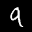

 0.0000 -0.4020
 1.0000  0.3087
 2.0000  0.0499
 3.0000  0.3936
 4.0000 -0.0039
 5.0000  0.1918
 6.0000 -0.4541
 7.0000 -0.1271
 8.0000  0.0129
 9.0000  0.0489
[torch.DoubleTensor of size 10x2]

Prediction 3 real label 9	


In [24]:
ndx = 126
itorch.image(test_data.data[ndx]:reshape(32,32))
y = net:forward(test_data.data[ndx])
print(torch.cat(torch.range(0,9),y,2))
logprob, digit = torch.max(y,1)
local digit = digit[1] - 1
local target = test_data.labels[ndx] - 1
print('Prediction ' .. digit .. ' real label ' .. target)

In [25]:
print(test_data.data[ndx]:reshape(32,32))

Columns 1 to 10
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000 

6  0.9883  0.8203
 0.0000  0.8945  0.9922  0.9922  0.7930  0.6250  0.0352  0.0938  0.9922  0.9922
 0.0000  0.0586  0.4180  0.4180  0.0234  0.0000  0.0000  0.0117  0.7422  0.9922
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.6875  0.9922
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.3633  0.9922
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.9961
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.6602
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.3125
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.000

.0000
 0.0000  0.0000
 0.0000  0.0000
 0.0000  0.0000
 0.0000  0.0000
[torch.DoubleTensor of size 32x32]

